$$
\epsilon(\omega) = \epsilon_{\infty} + \sum_{j=1}^{N} \frac{A_j \omega_j^2}{\omega_j^2 - \omega^2 - i \gamma_j \omega}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [24]:
def complex_permittivity_nunley2016(omega_cm):
    """Calculate the complex permittivity for a given frequency (in cm⁻¹)."""
    
    # Lorentz oscillator parameters (Table II in the article)
    oscillators = [
        {'A': 6.30, 'omega_j': 156.9, 'gamma_j': 12.8},   # L1
        {'A': 1.5,  'omega_j': 222.0, 'gamma_j': 35.0},   # L2
        {'A': 2.6,  'omega_j': 248.0, 'gamma_j': 42.0},   # L3
        {'A': 4.3,  'omega_j': 285.9, 'gamma_j': 28.0},   # L4
        {'A': 0.46, 'omega_j': 330.0, 'gamma_j': 46.0},   # L5
        {'A': 1.89, 'omega_j': 395.0, 'gamma_j': 44.0},   # L6
        {'A': 0.51, 'omega_j': 436.4, 'gamma_j': 18.6},   # L7
        {'A': 0.64, 'omega_j': 659.8, 'gamma_j': 36.5},   # L8
        {'A': 0.0045, 'omega_j': 787.0, 'gamma_j': 26.0}, # L9
    ]

    epsilon_inf = 4.0  # High-frequency dielectric constant
    
    epsilon = epsilon_inf * np.ones_like(omega_cm, dtype=np.complex128)
    for osc in oscillators:
        A = osc['A']
        omega_j = osc['omega_j']
        gamma_j = osc['gamma_j']
        numerator = A * omega_j**2
        denominator = omega_j**2 - omega_cm**2 - 1j * gamma_j * omega_cm
        epsilon += numerator / denominator
    return epsilon



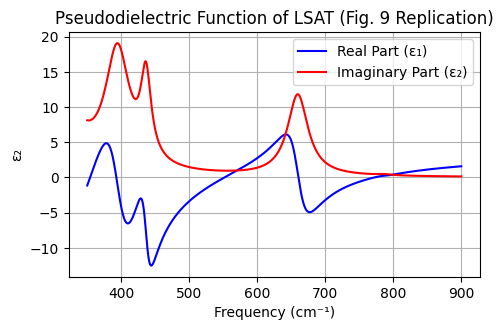

In [33]:

# Frequency range (0-1000 cm⁻¹)
omega_cm = np.linspace(350, 900, 1000)
epsilon = complex_permittivity_nunley2016(omega_cm)
plt.figure(figsize=(5, 6))

# Plot real part (ε₁)
plt.subplot(2, 1, 1)
plt.plot(omega_cm, (epsilon).real, 'b-', label='Real Part (ε₁)')
plt.title('Pseudodielectric Function of LSAT (Fig. 9 Replication)')
plt.ylabel('ε₁')
plt.grid(True)
plt.legend()

# Plot imaginary part (ε₂)
plt.subplot(2, 1, 1)
plt.plot(omega_cm, (epsilon).imag, 'r-', label='Imaginary Part (ε₂)')
plt.xlabel('Frequency (cm⁻¹)')
plt.ylabel('ε₂')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [26]:
from numba import njit

@njit
def calculate_beta(epsilon):
    return (epsilon-1)/(epsilon+1)

@njit
def calculate_rp(epsilon_mat, theta_i):
    epsilon_air = 1.0 
    
    n1 = np.sqrt(epsilon_air)   
    n2 = np.sqrt(epsilon_mat)      
    # snell law
    sin_theta_t = (n1 / n2) * np.sin(theta_i)
    cos_theta_t = np.sqrt(1 - sin_theta_t**2)  # non absorvent medium

    rp = (n2 * np.cos(theta_i) - n1 * cos_theta_t) / (n2 * np.cos(theta_i) + n1 * cos_theta_t)
    return rp

@njit
def calculate_f_parameter(g, radius, H, W, L):
    f = (g - (radius +2*H + W)/(2*L))*(np.log(4*L/(radius + 4*H +2*W)))/np.log(4*L/radius)
    return f

@njit
def calculate_H_t(t, A, Omega, H0):
    return H0 + A*(1 - np.cos(Omega*t))

@njit
def calculate_alpha_eff(beta, f0, f1):
    return 1 + 0.5 * (beta*f0)/(1 - beta*f1)

In [28]:
A_PARAMETER = 700**2 #cm⁻2

THETA_I = np.deg2rad(45)  # 45°

G = 0.7*(np.cos(0.06) + 1.0j*np.sin(0.06))

A = 18*1e-9 #m
RADIUS = 20*1e-9 #m
L = 300*1e-9 #m

W0 = 1.31*RADIUS
W1 = 0.5*RADIUS

Omega = 2*np.pi*(250*1e3) #rad/s
H0 = 0

def calculate_integrand(t, omega, n):
    epsilon = complex_permittivity_nunley2016(omega)
    beta = calculate_beta(epsilon)
    rp = calculate_rp(epsilon, THETA_I)
    
    H = calculate_H_t(t, A, Omega, H0)
    f0 = calculate_f_parameter(G, RADIUS, H, W0, L)
    f1 = calculate_f_parameter(G, RADIUS, H, W1, L)

    alpha_eff = calculate_alpha_eff(beta, f0, f1)

    integrand = ((1+rp)**2)*(alpha_eff) * (np.exp(-1.0j * Omega * n * t))
    return integrand


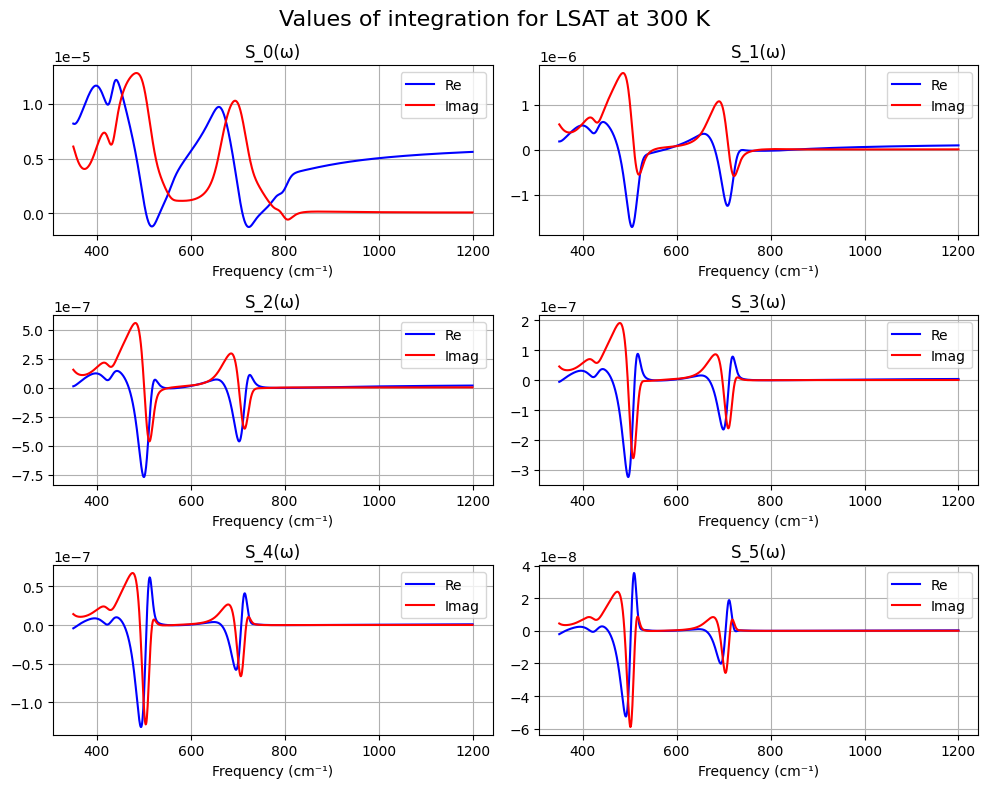

In [29]:
from scipy.integrate import quad_vec

omega_cm = np.linspace(350, 1200, 1000)  # Faixa experimental em cm⁻¹

n_values = [0, 1, 2, 3, 4, 5]
integrated_values = np.ndarray(shape=[len(omega_cm), len(n_values)], dtype=np.complex128)
 
for i, omega in enumerate(omega_cm):
    for j, n_value in enumerate(n_values):
        result, error = quad_vec(lambda x: calculate_integrand(x, omega, n_value), 0, 2*np.pi/Omega)
        integrated_values[i, j] = result

fig, axs = plt.subplots(figsize = (10,8),nrows=int(len(n_values)/2), ncols=2)
fig.suptitle(f'Values of integration for LSAT at 300 K', fontsize=16)
axes = axs.flatten()
for i, n_value in enumerate(n_values):
    axes[i].plot(omega_cm, np.real(integrated_values[:, i]), label='Re', color='blue')
    axes[i].plot(omega_cm, np.imag(integrated_values[:, i]), label='Imag', color='red')
    axes[i].set_xlabel('Frequency (cm⁻¹)')
    axes[i].set_title(f'S_{n_value}(ω)')
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()